In [286]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import time

import numpy as np

import torch
import torch.nn.functional as F

import cv2

import matplotlib
import matplotlib.pyplot as plt

from viz_svls import LS, SVLS
from datasets import get_datasets_brats

In [287]:
DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats(data_root=DATA_PATH)

In [288]:
ls = LS(4, 0.1).cuda()
svls = SVLS(4, 1.0).cuda()

In [289]:
sample_idx = 80
depth = 80

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()
print(image.shape)
print(label.shape)

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

# print(label_oh.shape)
# print(label_ls.shape)
# print(label_svls.shape)

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()

# print(label_slice_oh.shape)
# print(label_slice_ls.shape)
# print(label_slice_svls.shape)

image_slice = image[:, depth, ...].cpu().numpy()

torch.Size([4, 128, 192, 192])
torch.Size([1, 128, 192, 192])


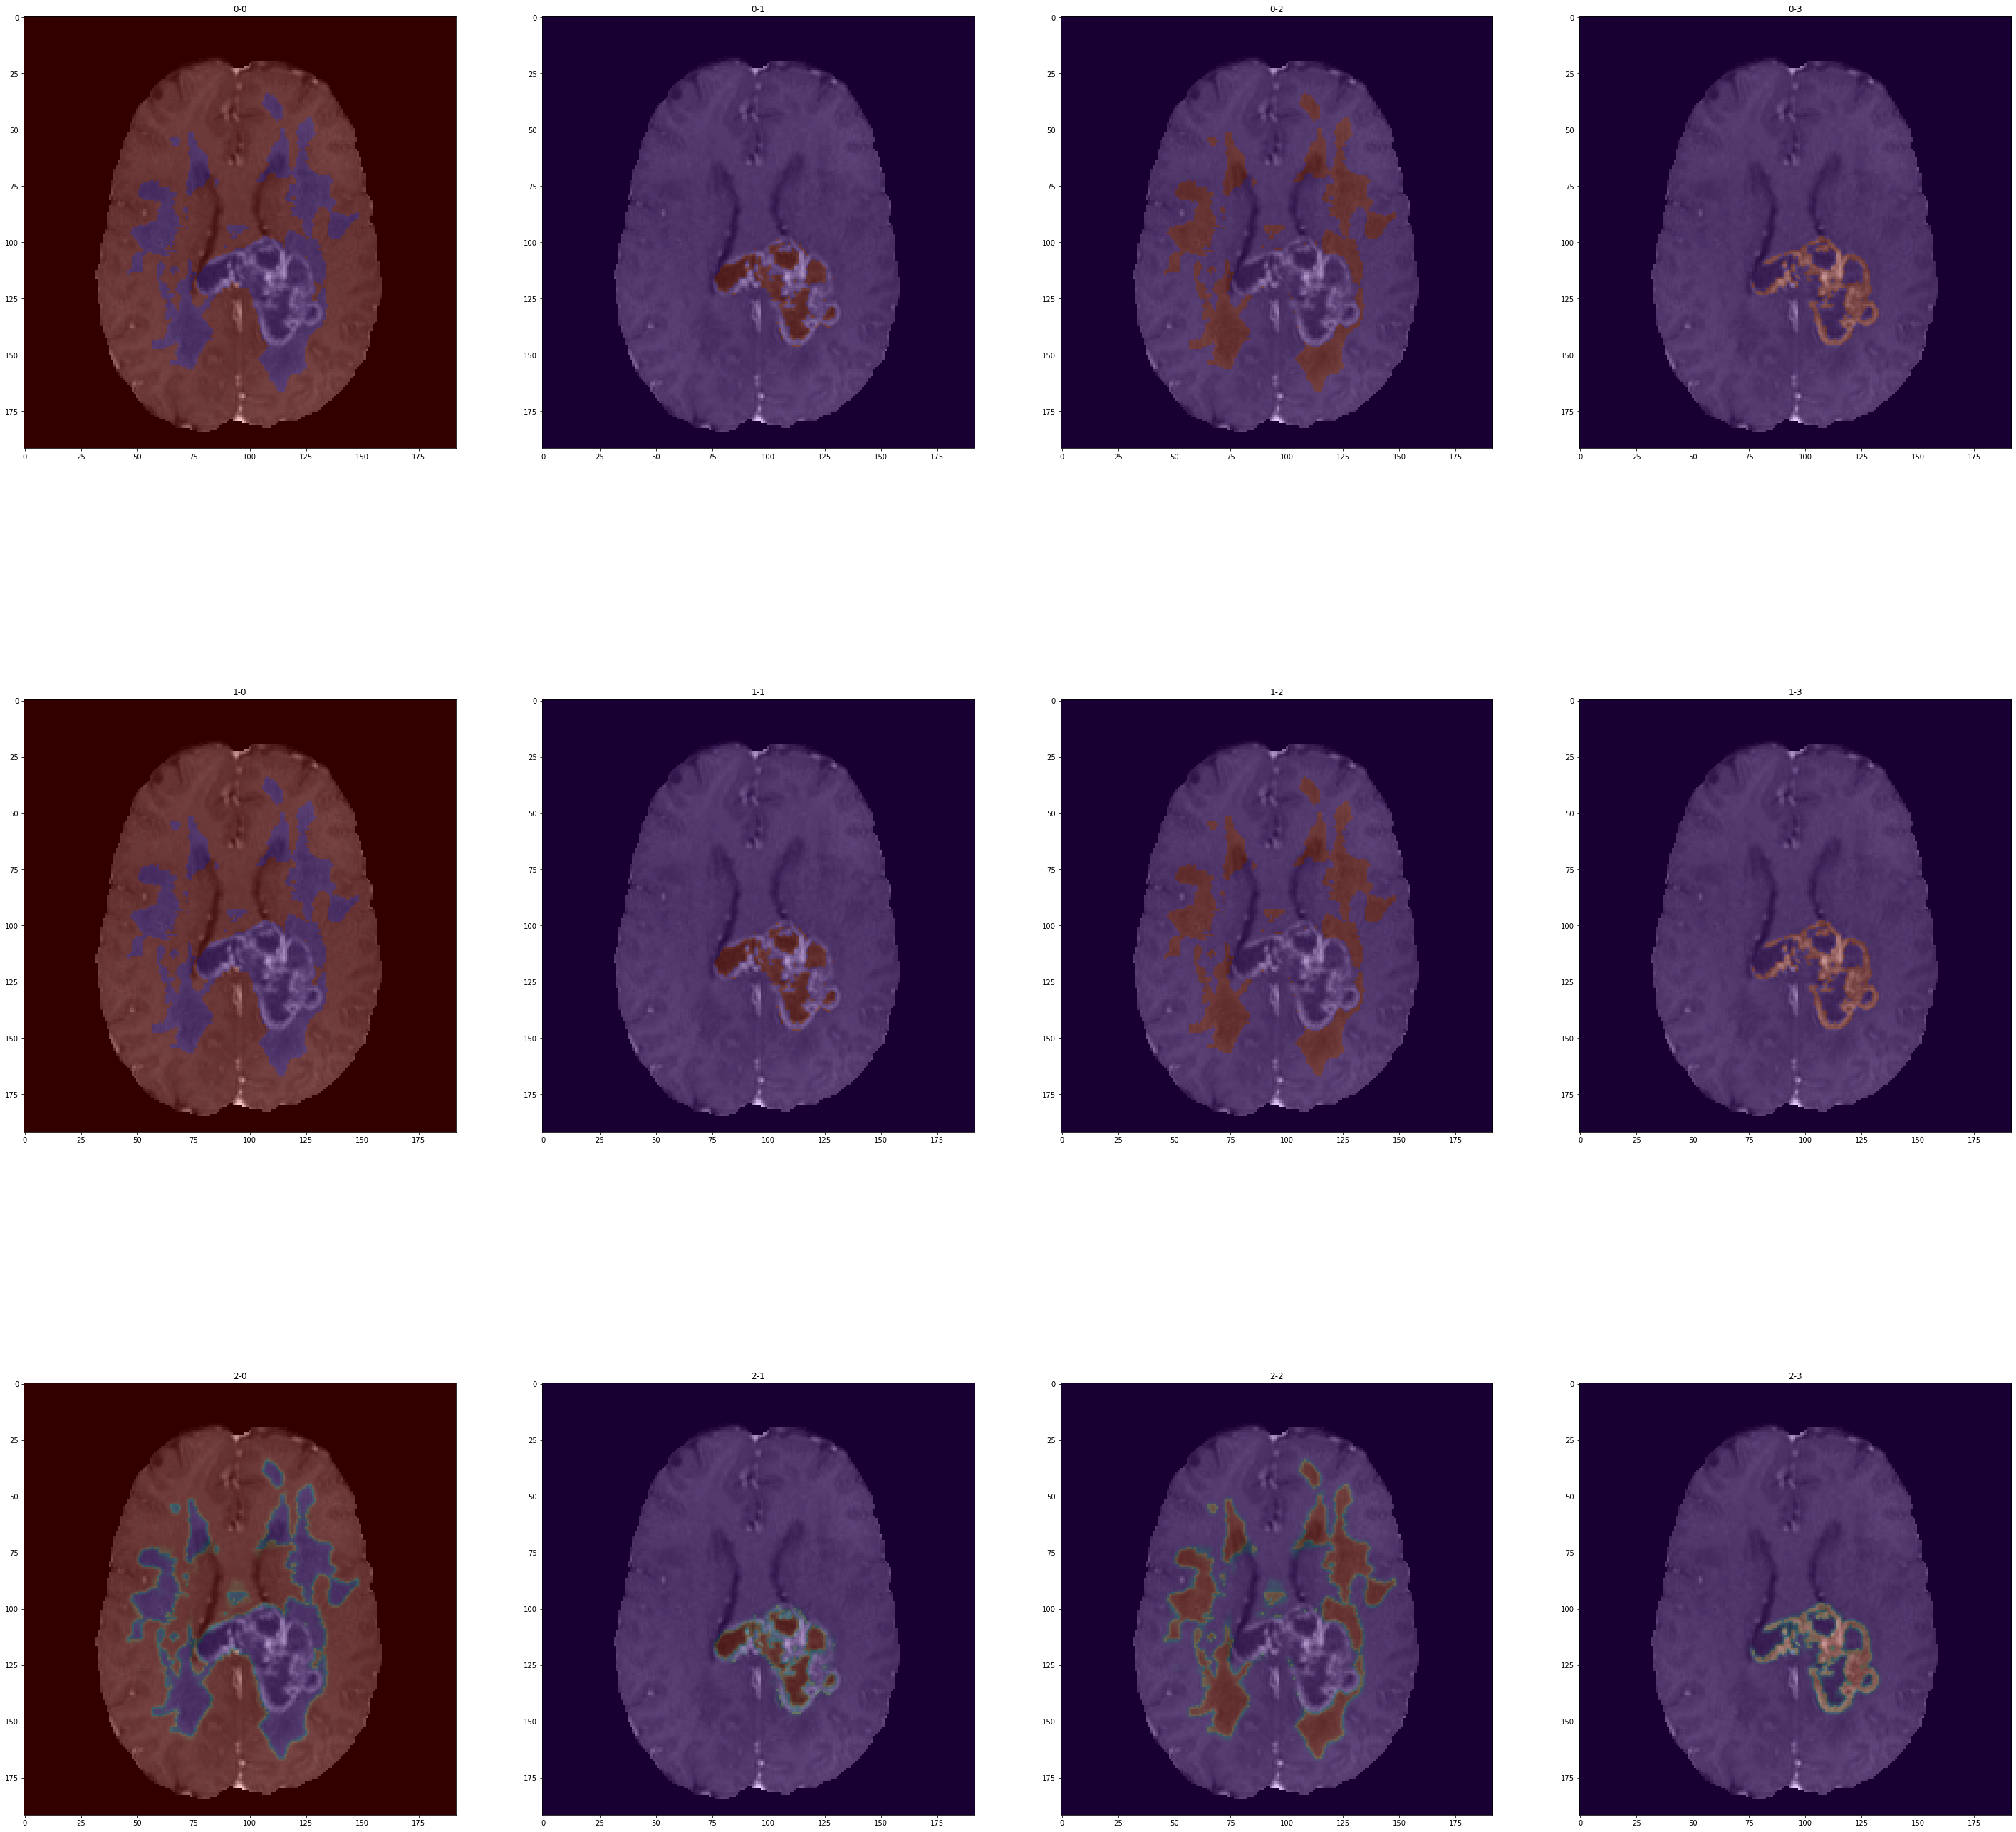

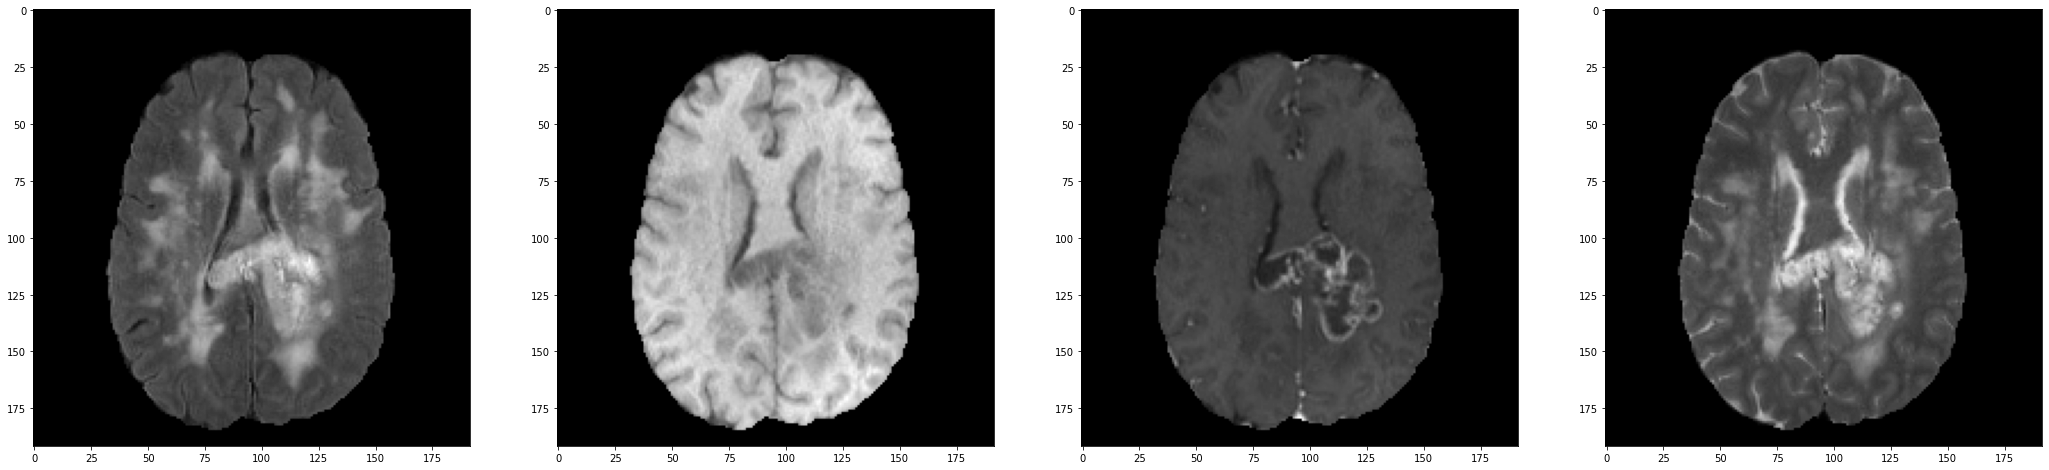

In [290]:
figure, axs = plt.subplots(3, 4, figsize=(50, 50))

_slices = [label_slice_oh, label_slice_ls, label_slice_svls]

for _type in range(3):
    _slice = _slices[_type]
    for _class in range(4):
        # print(f'{_type}-{_class}')
        # print(np.unique(_slice[_class+1]))
        axs[_type, _class].imshow(_slice[_class], cmap='rainbow')
        axs[_type, _class].imshow(image_slice[2], alpha=0.8, cmap='gray')
        axs[_type, _class].set_title(f'{_type}-{_class}')
plt.show()

figure, axs = plt.subplots(1, 4, figsize=(36, 36))
for seq in range(4):
    axs[seq].imshow(image_slice[seq], cmap='gray')
plt.show()

获取DTM

In [171]:
from scipy.ndimage import distance_transform_edt as distance

def compute_dtm01(img_gt, out_shape):
    """
    compute the normalized distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM) shape=out_shape
    sdf(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
             0; x out of segmentation
    normalize sdf to [0, 1]
    """

    normalized_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
            # ignore background
        for c in range(1, out_shape[1]):
            posmask = img_gt[b].astype(np.bool)
            if posmask.any():
                posdis = distance(posmask)
                normalized_dtm[b][c] = posdis/np.max(posdis)

    return normalized_dtm

def compute_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM) 
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # batch size
        for c in range(1, out_shape[1]):
            posmask = img_gt[b].astype(np.bool)
            if posmask.any():
                posdis = distance(posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm

In [172]:
label_map = label_oh[:, 2].cpu().numpy()  # only the second class
print(label_map.shape)

dtm01 = compute_dtm01(label_map, [1, 2, 128, 192, 192])
print(dtm01.shape)

dtm = compute_dtm(label_map, [1, 2, 128, 192, 192])
print(dtm.shape)

(1, 128, 192, 192)


/tmp/ipykernel_79630/3925553712.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  posmask = img_gt[b].astype(np.bool)


(1, 2, 128, 192, 192)


/tmp/ipykernel_79630/3925553712.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  posmask = img_gt[b].astype(np.bool)


(1, 2, 128, 192, 192)


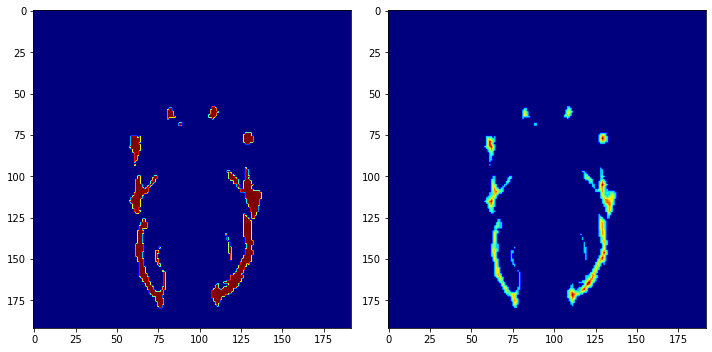

In [173]:
depth = 60

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
ax1, ax2 = axs.ravel()
ax1.imshow(label_map[0, depth], cmap='jet')
ax2.imshow(dtm01[0, 1, depth], cmap='jet')
plt.tight_layout()
plt.show()

查看DTM距离的分布

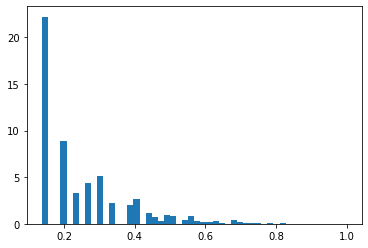

In [174]:
plt.figure()
plt.hist(dtm01[dtm01>0].ravel(), bins=50, density=True)
plt.show()

尝试进行sigmoid

In [175]:
dtm_sigmoid = 1 / (1 + np.exp(-dtm))

尝试进行tanh

In [176]:
dtm_tanh = np.tanh(dtm01 * 10.0)

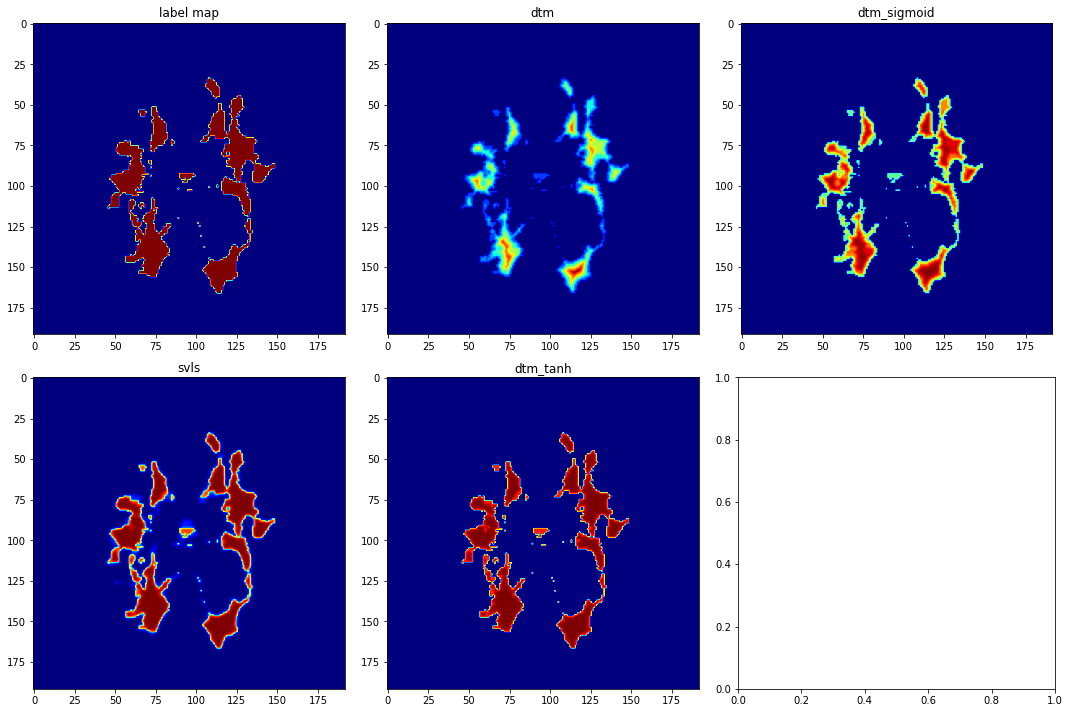

In [177]:
depth = 80

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.ravel()
ax1.imshow(label_map[0, depth], cmap='jet')
ax1.set_title('label map')
ax2.imshow(dtm[0, 1, depth], cmap='jet')
ax2.set_title('dtm')
ax3.imshow(dtm_sigmoid[0, 1, depth], cmap='jet')
ax3.set_title('dtm_sigmoid')
ax4.imshow(label_svls[0, 2, depth, ...].cpu().numpy(), cmap='jet')
ax4.set_title('svls')
ax5.imshow(dtm_tanh[0, 1, depth], cmap='jet')
ax5.set_title('dtm_tanh')
plt.tight_layout()
plt.show()

In [14]:
# plt.figure()
# plt.hist(dtm_sigmoid[dtm_sigmoid>0.5].ravel(), bins=50, density=True)
# plt.show()

In [15]:
# plt.figure()
# plt.hist(dtm_tanh[dtm_tanh>0.0].ravel(), bins=50, density=True)
# plt.show()

In [16]:
# label_svls_ = label_svls[0, 2, ...].cpu().numpy()

# plt.figure()
# plt.hist(label_svls_[label_svls_>0], bins=50, density=True)
# plt.show()

如何切分连通域？

[path1 直接得到label_map的连通域

In [178]:
from skimage import morphology
from skimage import measure

label_domains, num = measure.label(label_map[0], return_num=True, connectivity=1)

print(np.unique(label_domains))
print(num)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173]
173


path2 对label_map进行腐蚀，得到几个连通域

为什么要腐蚀，因为要防止极细的连接

In [188]:
label_map_erosion = morphology.erosion(label_map[0], morphology.octahedron(4))
label_domains, num = measure.label(label_map_erosion, return_num=True, connectivity=1)

print(np.unique(label_domains))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]


path3 先对骨骼点进行膨胀，取并集，然后整体腐蚀，得到连通域

In [268]:
label_map_skeleton = morphology.skeletonize(label_map[0])
label_map_skeleton_dilation = morphology.dilation(label_map_skeleton, morphology.ball(2))

label_map_ = np.maximum(label_map[0], label_map_skeleton_dilation)

label_map_erosion = morphology.erosion(label_map_, morphology.ball(1))
label_domains, num = measure.label(label_map_erosion, return_num=True)

print(np.unique(label_domains))

/home/s2018013343/anaconda3/lib/python3.8/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


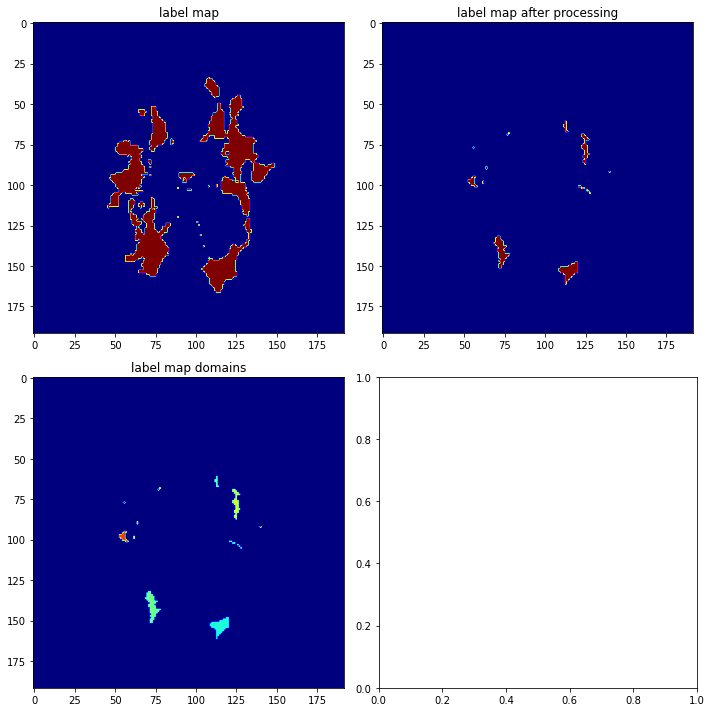

In [189]:
depth = 80

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.imshow(label_map[0, depth], cmap='jet')
ax1.set_title('label map')
ax3.imshow(label_domains[depth], cmap='jet')
ax3.set_title('label map domains')
ax2.imshow(label_map_erosion[depth], cmap='jet')
ax2.set_title('label map after processing')

plt.tight_layout()
plt.show()

path4] 切分获得不同的超结构区

- 进行不同程度的腐蚀
- 看连通域消失的次数，决定作为这个结构大小的评价，并把该值赋值到结构（label）
- 并把label进行expand，之后可能会接壤，形成超结构
- 使用形态学运算，将超结构变得规则一些   （这一步是否有必要？）
- 每一个超结构对应一个scale

对各个连通域进行拓展，注意不是膨胀，拓展可以保证各连通域不彼此重叠

In [169]:
from skimage.segmentation import expand_labels

dtm_domains_expand = expand_labels(label_domains, 4)
np.unique(dtm_domains_expand)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152])

不同连通域之间如何统一？

[path1 对每个连通域分别填充各自的最大距离

In [34]:
dtm_domain_max = np.zeros_like(dtm[0, 1])

for i in range(1, num+1):  # exclude background
    # print(i)
    print(np.min(dtm[0, 1][dtm_domains_expand==i]))
    print(np.min(dtm[0, 1][label_domains==i]))
    dtm_domain_max[dtm_domains_expand==i] = np.max(dtm[0, 1][dtm_domains_expand==i])

print(np.unique(dtm_domain_max))
print(dtm_domain_max.shape)

0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0


并由此归一化

In [284]:
dtm01_ = np.divide(dtm[0, 1], dtm_domain_max, where=(dtm_domain_max!=0)) 
# np.unique(dtm01_)

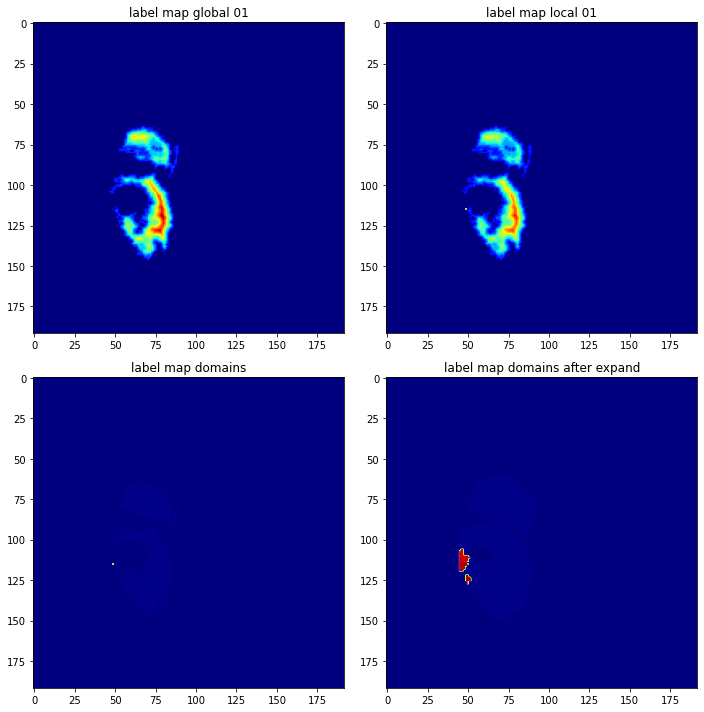

In [287]:
depth = 70

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.imshow(dtm01[0, 1, depth], cmap='jet')
ax1.set_title('label map global 01')
ax2.imshow(dtm01_[depth], cmap='jet')
ax2.set_title('label map local 01')
ax3.imshow(label_domains[depth], cmap='jet')
ax3.set_title('label map domains')
ax4.imshow(dtm_domains_expand[depth], cmap='jet')
ax4.set_title('label map domains after expand')
plt.tight_layout()
plt.show()

path2 每个连通域分别填充该连通域的体积

In [311]:
dtm_domain_volume = np.zeros_like(dtm[0, 1])

for i in range(1, num+1):  # exclude background
    # print(':' + str(i))
    # print(np.sum(label_domains==i))
    dtm_domain_volume[label_domains==i] = np.sum(label_domains==i)

print(len(np.unique(label_domains)))
print(np.unique(dtm_domain_volume))
print(dtm_domain_volume.shape)

147
[0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 7.0000e+00 9.0000e+00 1.0000e+01 1.7000e+01 2.2000e+01
 1.0200e+02 6.3242e+04]
(128, 192, 192)


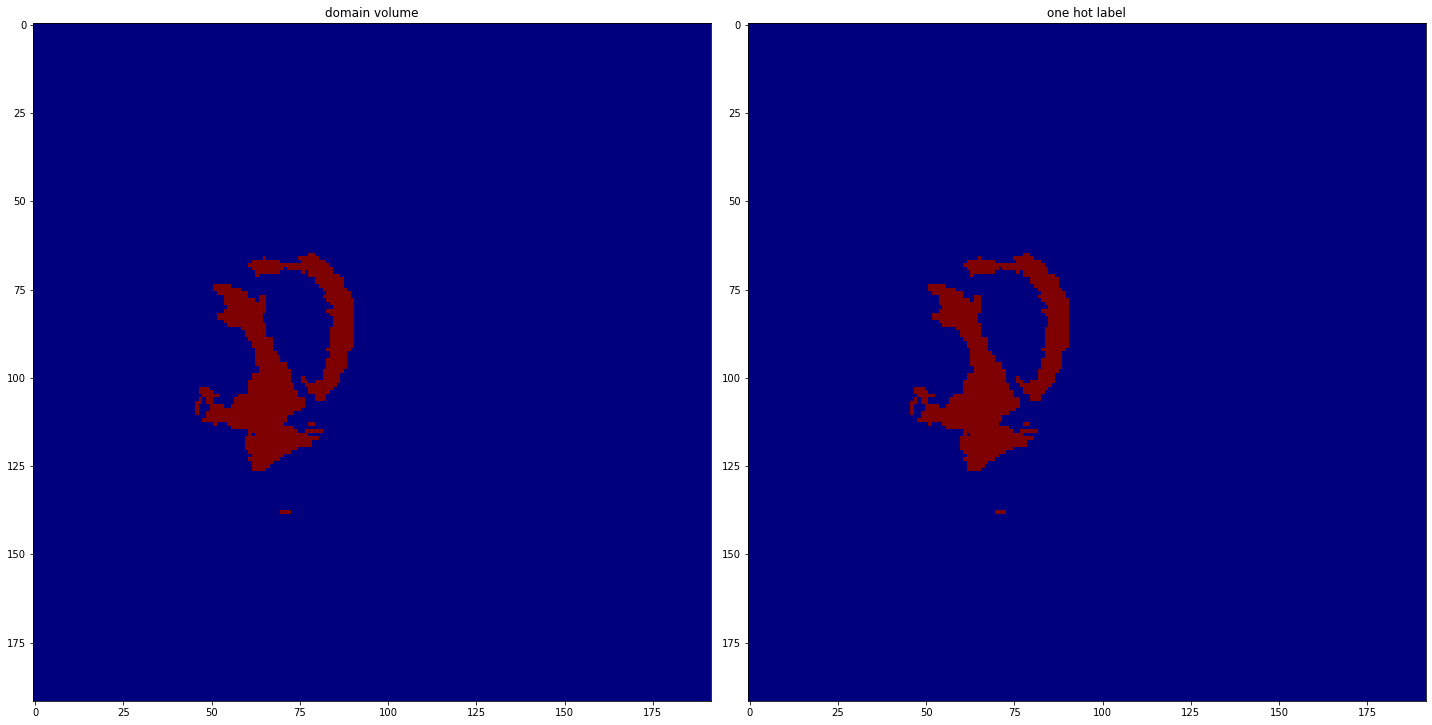

In [312]:
depth = 80

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axs.ravel()

ax1.imshow(dtm_domain_volume[depth], cmap='jet')
ax1.set_title("domain volume")
ax2.imshow(label_map[0, depth], cmap='jet')
ax2.set_title("one hot label")
plt.tight_layout()
plt.show()

In [313]:
np.unique(dtm_domain_volume)

array([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
       5.0000e+00, 6.0000e+00, 7.0000e+00, 9.0000e+00, 1.0000e+01,
       1.7000e+01, 2.2000e+01, 1.0200e+02, 6.3242e+04])

可视化加系数后的tanh函数

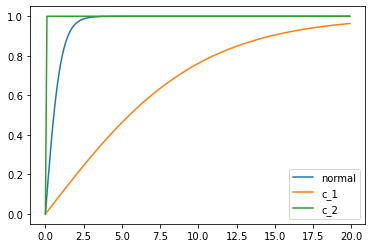

In [316]:
c_1 = 0.1
c_2 = 100

x = np.arange(0, 20, 0.1)
y_0 = np.tanh(x)
y_1 = np.tanh(c_1 * x)
y_2 = np.tanh(c_2 * x)

plt.figure()
plt.plot(x, y_0, label="normal")
plt.plot(x, y_1, label="c_1")
plt.plot(x, y_2, label="c_2")
plt.legend()
plt.show()

根据 dist = tanh(100 / V * dtm) 标准化距离

In [353]:
alpha = 3e4

dtm_ = np.tanh(alpha * dtm[0, 1] * np.divide(1, dtm_domain_volume, where=(dtm_domain_volume>0)))

np.unique(dtm_)

array([0.        , 0.44172205, 0.58554405, 0.67595607, 0.73921055,
       0.78593918, 0.8216777 , 0.87208383, 0.89024486, 0.90516348,
       0.91754935, 0.92792692, 0.9366916 , 0.94414656, 0.95602062,
       0.96077348, 0.96490528, 0.96851263, 0.97167459, 0.97445629,
       0.97691179, 0.98101736, 0.98273726, 0.98427296, 0.98564755,
       0.98798956, 0.98898853, 0.9907059 , 0.9914448 , 0.99211537,
       0.99272491, 0.99327981, 0.99378571, 0.9942476 , 0.99505642,
       0.9954107 , 0.99573581, 0.99603448, 0.99630918, 0.99656209,
       0.99679519, 0.99720882, 0.99739237, 1.        ])

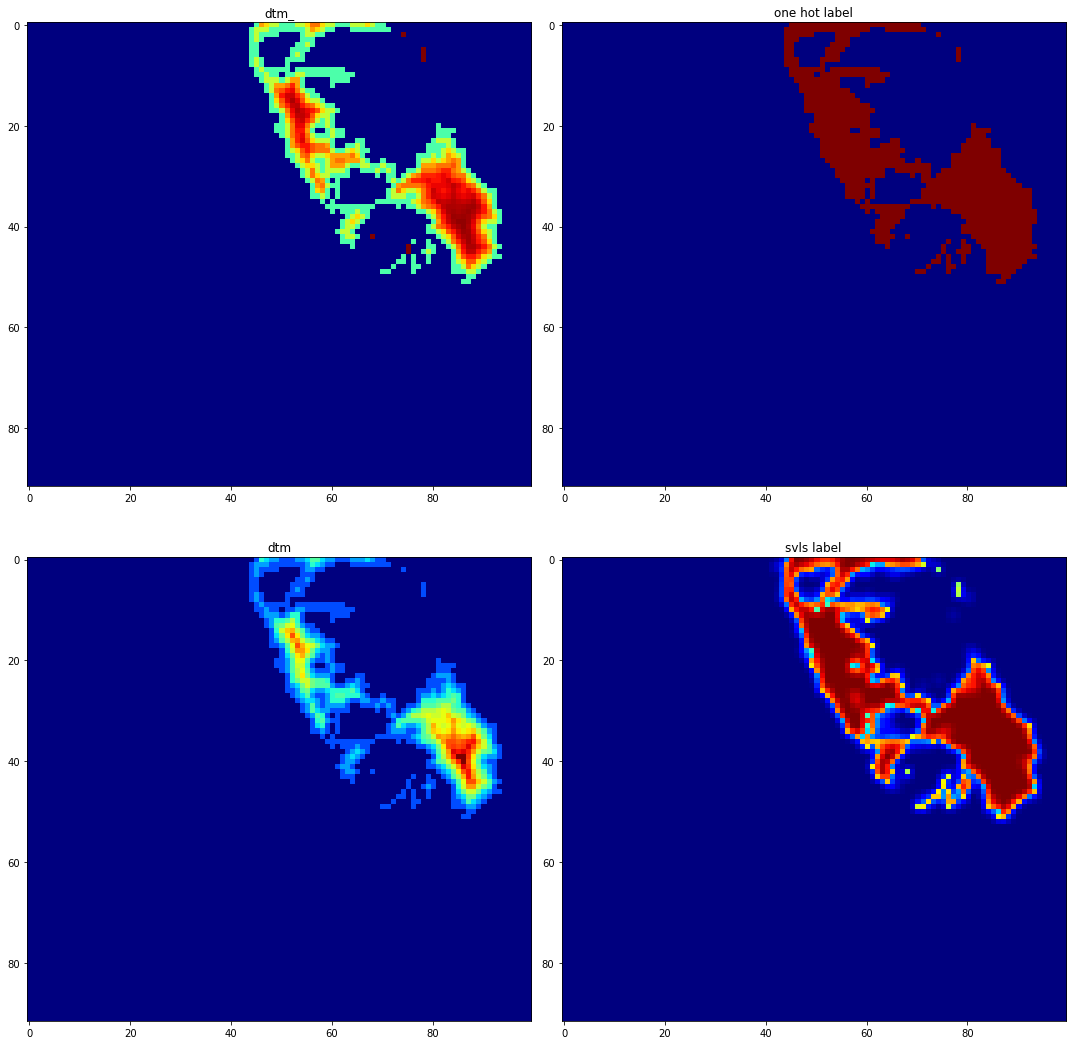

In [356]:
depth = 40

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs.ravel()

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)

ax1_ = ax1.imshow(dtm_[depth][100:, :100], cmap='jet', norm=norm)
ax1.set_title("dtm_")
ax2_ = ax2.imshow(label_map[0, depth][100:, :100], cmap='jet', norm=norm)
ax2.set_title("one hot label")
ax3_ = ax3.imshow(dtm[0, 1, depth][100:, :100], cmap='jet')
ax3.set_title("dtm")
ax4_ = ax4.imshow(label_svls[0, 2, depth][100:, :100].cpu().numpy(), cmap='jet', norm=norm)
ax4.set_title("svls label")

# fig.colorbar()
plt.tight_layout()
plt.show()

In [338]:
label_svls.shape

torch.Size([1, 4, 128, 192, 192])

path3 每个连通域分别填充表面积和体积之比

In [170]:
dtm_domain_sv = np.zeros_like(dtm[0, 1])

for i in range(1, num+1):  # exclude background
    # print(':' + str(i))
    # print(np.sum(label_domains==i))
    surface_area = np.sum(np.logical_and(dtm_domains_expand==i, dtm==1))
    volume = np.sum(label_domains==i)
    dtm_domain_sv[dtm_domains_expand==i] = surface_area / volume

print(len(np.unique(dtm_domain_sv)))
print(np.unique(dtm_domain_sv))
print(dtm_domain_sv.shape)

88
[ 0.          0.87799652  1.20333547  1.71978752  2.          3.
  3.03636364  3.25954198  3.5         4.          4.33333333  4.50574713
  5.          5.5         5.83333333  6.          7.          7.20454545
  7.5         7.52777778  7.625       7.84375     8.          8.28571429
  8.36363636  8.5         8.54545455  9.15384615 10.         10.33333333
 10.5        10.6875     11.         11.23076923 11.64705882 12.
 13.         13.66666667 14.         15.         15.09090909 15.5
 15.83333333 16.         16.5        17.         18.         19.
 20.         20.33333333 21.         21.33333333 22.         22.5
 23.5        23.66666667 24.         25.         25.4        25.5
 26.         27.         28.         29.5        30.         31.
 32.         33.33333333 33.5        34.33333333 36.         38.
 39.         40.         42.         44.         46.         47.
 48.         51.         54.         55.         56.         57.
 61.         73.         75.         77.        ]
(1

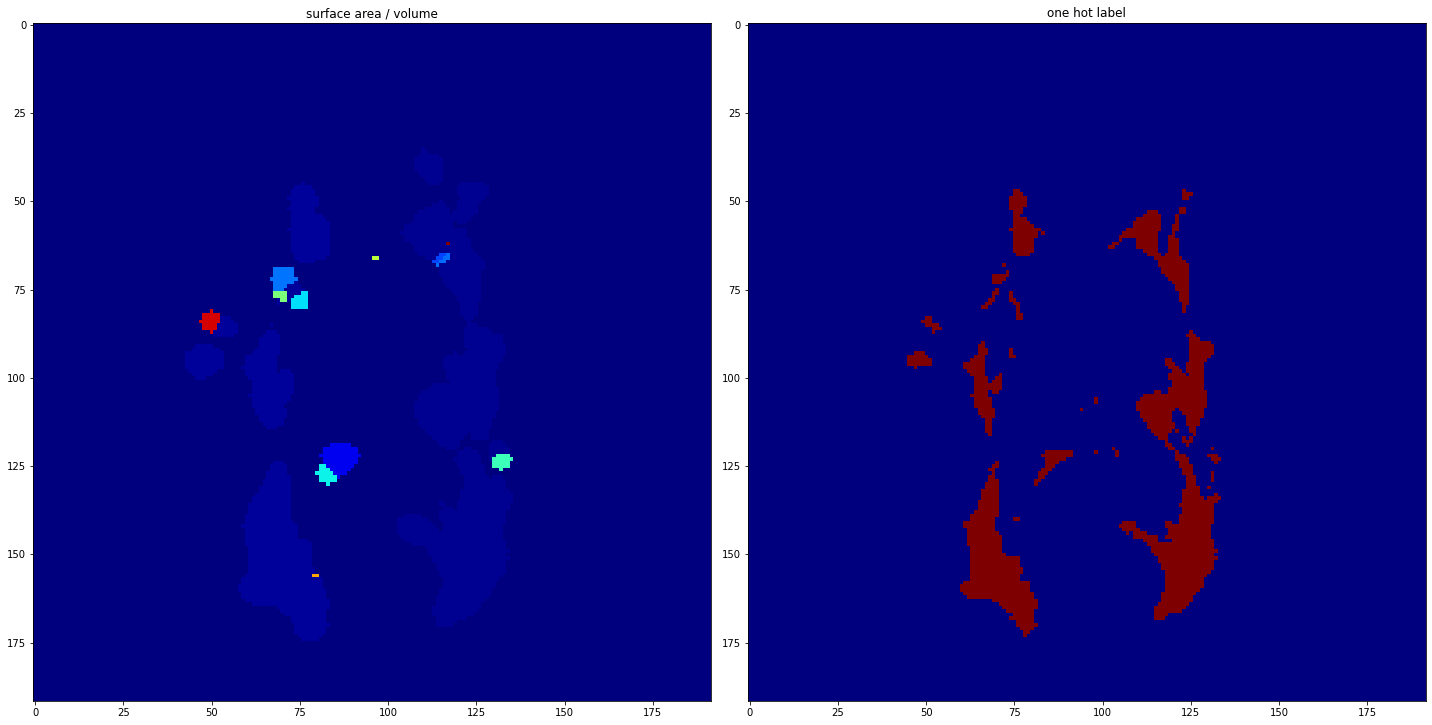

In [90]:
depth = 70

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axs.ravel()

ax1.imshow(dtm_domain_sv[depth], cmap='jet')
ax1.set_title("surface area / volume")
ax2.imshow(label_map[0, depth], cmap='jet')
ax2.set_title("one hot label")
plt.tight_layout()
plt.show()

path 4 每个连通域分别对距离进行规定化

In [ ]:
for i in range(0, num+1):
    dists = dtm[0, 1][label_domains==i].ravel()
    print(np.unique(dists))
    plt.figure()
    plt.hist(dists)
    plt.show()

path 5] 每个连通域内部进行z-score标准化

In [237]:
dtm_domain_z = np.zeros_like(dtm[0, 1])

for i in range(0, num+1):
    dtm_domain_z[label_domains==i] = \
    (dtm[0, 1][label_domains==i] - np.mean(dtm[0, 1][label_domains==i])) / \
    (np.std(dtm[0, 1][label_domains==i]) + 1e-6)


print(np.unique(dtm_domain_z))
print(dtm_domain_z.shape)

[-0.87568051 -0.46074507 -0.16221894 -0.14235391  0.          0.12606225
  0.36254164  0.57633534  0.95593312  1.12780501  1.29036548  1.4449816
  1.59271544  1.73441161  1.87075492  2.12954776  2.25286793  2.37261132
  2.48907218  2.60250654  2.71313875  2.82116675  3.03009395  3.13129052
  3.2304826   3.32778479  3.51712658  3.60934779  3.78928951  3.87715076
  3.96369057  4.04896681  4.13303328  4.21594005  4.29773382  4.45815422
  4.53686007  4.61461179  4.69144328  4.76738646  4.84247144  4.91672668
  5.06285414  5.13477604  6.16431985]
(128, 192, 192)


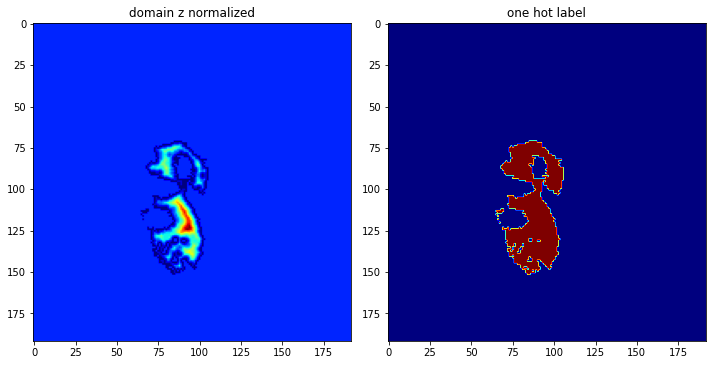

In [239]:
depth = 70

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
ax1, ax2 = axs.ravel()

ax1.imshow(dtm_domain_z[depth], cmap='jet')
ax1.set_title("domain z normalized")
ax2.imshow(label_map[0, depth], cmap='jet')
ax2.set_title("one hot label")
plt.tight_layout()
plt.show()

对整个label map计算伪径向相对距离，到骨架距离 / (到边界距离 + 到骨架距离)


In [233]:
from scipy.spatial.distance import cdist


def calculate_pseudo_relative_radius(label_map):
    # get dtm
    distance_to_surface = distance(label_map)

    # get distance to skeleton
    skeleton = morphology.skeletonize(label_map)
    # the label pointset
    coords_label = np.array(np.where(label_map)).T
    # the skeleton pointset
    coords_skeleton = np.array(np.where(skeleton)).T
    # get distance to skeleton
    distance_to_skeleton_ = cdist(coords_label, coords_skeleton, metric='euclidean')
    distance_to_skeleton_ = np.min(distance_to_skeleton_, axis=1)
    # remap to the original shape
    x, y, z = zip(*coords_label)
    distance_to_skeleton = np.zeros_like(label_map) * 1.0
    distance_to_skeleton[x, y, z] = distance_to_skeleton_

    # pseudo relative radius
    prr = np.divide(distance_to_surface, distance_to_surface + distance_to_skeleton, where=(distance_to_surface>0))

    return prr, distance_to_surface, distance_to_skeleton

def calculate_pseudo_relative_radius_2d(label_map):
    # get dtm
    distance_to_surface = distance(label_map)

    # get distance to skeleton
    skeleton = morphology.skeletonize(label_map)
    # the label pointset
    coords_label = np.array(np.where(label_map)).T
    # the skeleton pointset
    coords_skeleton = np.array(np.where(skeleton)).T
    # get distance to skeleton
    distance_to_skeleton_ = cdist(coords_label, coords_skeleton, metric='euclidean')
    distance_to_skeleton_ = np.min(distance_to_skeleton_, axis=1)
    # remap to the original shape
    x, y = zip(*coords_label)
    distance_to_skeleton = np.zeros_like(label_map) * 1.0
    distance_to_skeleton[x, y] = distance_to_skeleton_

    # pseudo relative radius
    prr = np.divide(distance_to_surface, distance_to_surface + distance_to_skeleton, where=(distance_to_surface>0))

    return prr, distance_to_surface, distance_to_skeleton

In [234]:
prr, d_surface, d_skeleton = calculate_pseudo_relative_radius(label_map[0])
prr_2d, d_surface_2d, d_skeleton_2d = calculate_pseudo_relative_radius_2d(label_map[0, 70])

In [1]:
depth = 70

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.imshow(label_map[0, depth], cmap='jet')
ax1.set_title('oh_label')
ax2.imshow(prr[depth], cmap='jet')
ax2.set_title('prr')
ax3.imshow(d_surface[depth], cmap='jet')
ax3.set_title('dist_to_surface')
ax4.imshow(d_skeleton[depth], cmap='jet')
ax4.set_title('dist_to_skeleton')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.imshow(label_map[0, 70], cmap='jet')
ax1.set_title('oh_label')
ax2.imshow(prr_2d, cmap='jet')
ax2.set_title('prr')
ax3.imshow(d_surface_2d, cmap='jet')
ax3.set_title('dist_to_surface')
ax4.imshow(d_skeleton_2d, cmap='jet')
ax4.set_title('dist_to_skeleton')
plt.tight_layout()
plt.show()

被腐蚀掉的小结构都采用one-hot

直接在label smoothing的基础上增加一个head用以预测dtm，看能否提高model calibration

将原来的label map resize放大，最近邻插值，然后SVLS，再resize回来，看能否保留小的结构

使用multi scale，然后选最合适的scale？每个位置对应的scale不同？每个位置选择与one-hot相差最小的scale？用不同scale下label assigned的标准差确定这个位置对scale的敏感性，然后再由此做出决定？作差法选择变化较大的位置作为需要补偿的位置？

到底收敛的标准是什么？？？？？？？？

In [284]:
def scale_svls(label, operator=None, scale_factor=2.0):
    n, z, x, y = label.shape
    
    if operator is None:
        svls = SVLS(classes=4).cuda()
    else:
        svls = operator

    aff = torch.FloatTensor([[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]])
    aff.expand(n, 3, 4)
    grid_up = torch.nn.functional.affine_grid(aff, size=(n, 1, int(scale_factor * z), int(scale_factor * x), int(scale_factor * y))).cuda()
    grid_down = torch.nn.functional.affine_grid(aff, size=(n, 1, z, x, y)).cuda()

    # up sample
    label_resample = F.grid_sample(label[:, None, ...].float(), grid_up, mode='nearest')

    print(label_resample.shape)

    # svls
    label_resample_svls = svls(label_resample[:, 0, ...])

    print(label_resample_svls.shape)

    # down sample
    label_resample_svls_resample = F.grid_sample(label_resample_svls.float(), grid_down, mode='bilinear')

    return label_resample_svls_resample

In [285]:
sample_idx = 55

item = train_dataset[sample_idx]
label = item['label'].cuda()
label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

label_svls_multi_scales = list()

scales = [ 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2]

operator = SVLS(classes=4).cuda()

label_assigned = list()
error_means = list()
error_stds = list()
# error_cvs = list()

target_depth = 60
target_y = 60
target_x = 112

for scale in scales:
    label_scale_svls = scale_svls(label, operator=operator, scale_factor=scale)
    # label_svls_multi_scales.append(label_scale_svls)
    
    label_scale_svls_ = label_scale_svls.cpu().numpy()
    print(label_scale_svls_[0, :, target_depth, target_y, target_x])
    label_assigned.append(label_scale_svls_[0, 2, target_depth, target_y, target_x])

    # 这里计算均值和标准差是否需要只考虑不是背景的voxel？
    error_std, error_mean = torch.std_mean(torch.abs(label_scale_svls - label_oh).sum(dim=1))
    error_means.append(error_mean.cpu().numpy())
    error_stds.append(error_std.cpu().numpy())
    # error_cvs.append((error_std / error_mean).cpu().numpy())

plt.figure()
plt.plot(scales, label_assigned, label="label_assigned")
plt.legend()
plt.show()

plt.figure()
plt.plot(scales, error_means, label="error_means")
plt.legend()
plt.show()

plt.figure()
plt.plot(scales, error_stds, label="error_stds")
plt.legend()
plt.show()

# plt.figure()
# plt.plot(scales, error_cvs, label="error_cvs")
# plt.legend()
# plt.show()

torch.Size([1, 115, 172, 172])


/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


RuntimeError: number of dims don't match in permute

  0%|          | 0/3 [00:00<?, ?it/s]/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


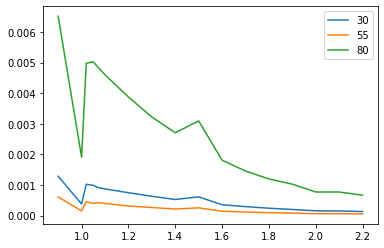

In [266]:
from tqdm import tqdm

sample_idxs = [30, 55, 80]
scales = [ 0.9, 1.0, 1.02, 1.05, 1.07, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2]
operator = SVLS(classes=4).cuda()

plt.figure()

for sample_idx in tqdm(sample_idxs):
    item = train_dataset[sample_idx]
    label = item['label'].cuda()
    label_oh = torch.permute(F.one_hot(label, num_classes=4), (0, 4, 1, 2, 3))
    errors = list()

    for scale in scales:
        label_scale_svls = scale_svls(label, operator=operator, scale_factor=scale)
        label_scale_svls_ = label_scale_svls.cpu().numpy()

        error = torch.square(label_scale_svls - label_oh).sum(dim=1).mean().cpu().numpy()
        errors.append(error)

    plt.plot(scales, errors, label=str(sample_idx))

plt.legend()
plt.show()

In [22]:
sample_idx = 80

item = train_dataset[sample_idx]
label = item['label'].cuda()
label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

label_scale_svls = scale_svls(label, scale_factor=2.0)
label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_svls = svls(label)

diff = label_scale_svls - label_svls

abs_sum = diff.abs().sum(axis=1, keepdim=True)

label_svls_refined = torch.where(abs_sum > 0.1, label_scale_svls, label_svls)

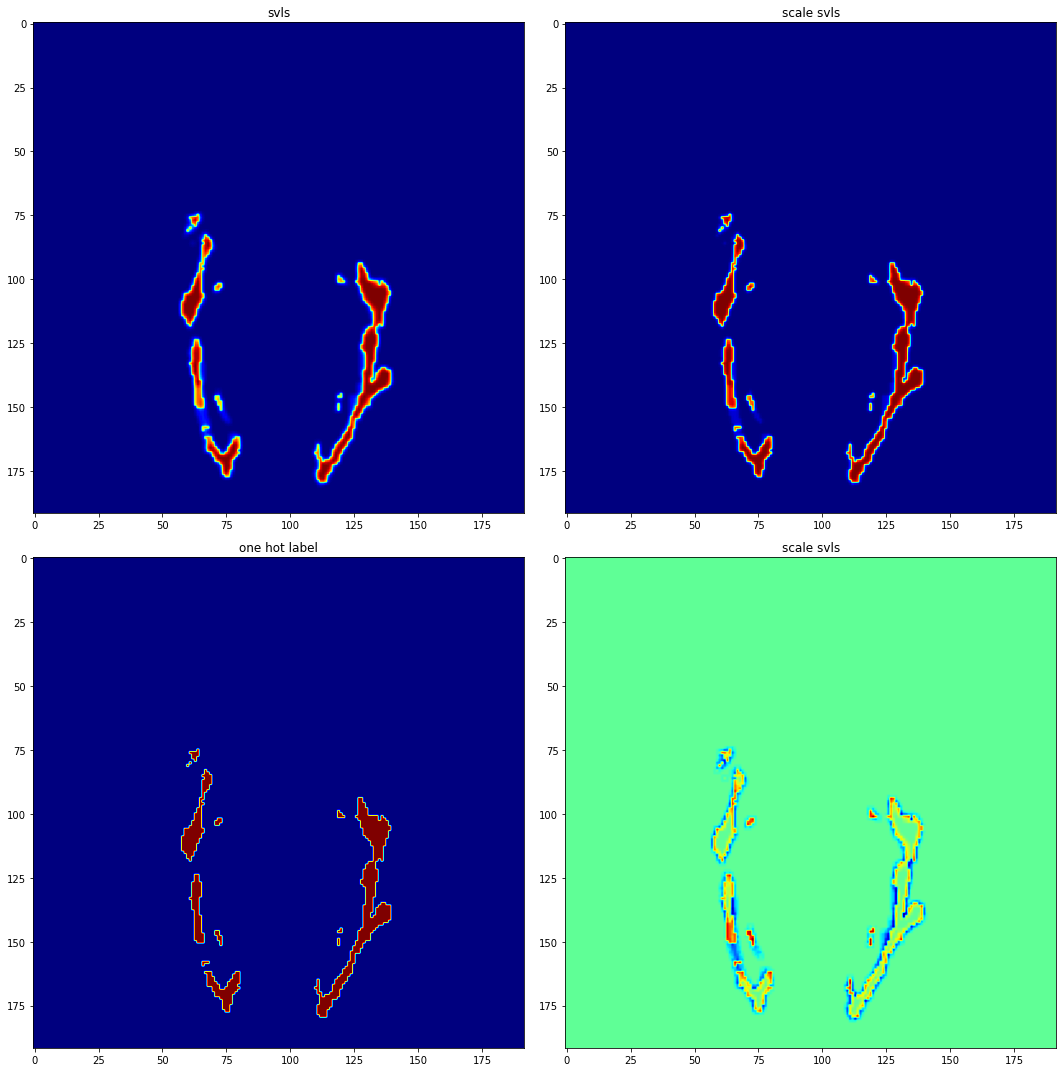

In [54]:
depth = 55

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs.ravel()

ax1.imshow(label_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax1.set_title("svls")
ax2.imshow(label_scale_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax2.set_title("scale svls")
ax3.imshow(label_oh[0, 2, depth,].cpu().numpy(), cmap="jet")
ax3.set_title("one hot label")
ax4.imshow(diff[0, 2, depth,].cpu().numpy(), cmap="jet")
ax4.set_title("scale svls")

# def on_press(event):
#     print("my position:" ,event.button,event.xdata, event.ydata)
# fig.canvas.mpl_connect('button_press_event', on_press)

plt.tight_layout()
plt.show()

# pos=plt.ginput(3)
# print(pos)

查看不同scale情况下与原本one-hot的mse

In [64]:
label_oh.shape

torch.Size([1, 4, 128, 192, 192])

[path1 根据dtm确定每个voxel应该使用的scale

In [24]:
print(np.min(dtm01[0, 1]))
print(np.max(dtm01[0, 1]))

0.0
1.0


In [68]:
scales = 3

scale_map = np.round(dtm01 * scales)

scale_map = (scale_map - 3) * -1

scale_map = scale_map.astype(np.uint8)

scale_map_repeat = np.repeat(scale_map[:, 1:2], repeats=4, axis=1)

print(scale_map_repeat.shape)

print(np.max(scale_map_repeat[0, 2]))
print(np.min(scale_map_repeat[0, 2]))

(1, 4, 128, 192, 192)
3
0


可视化scale map

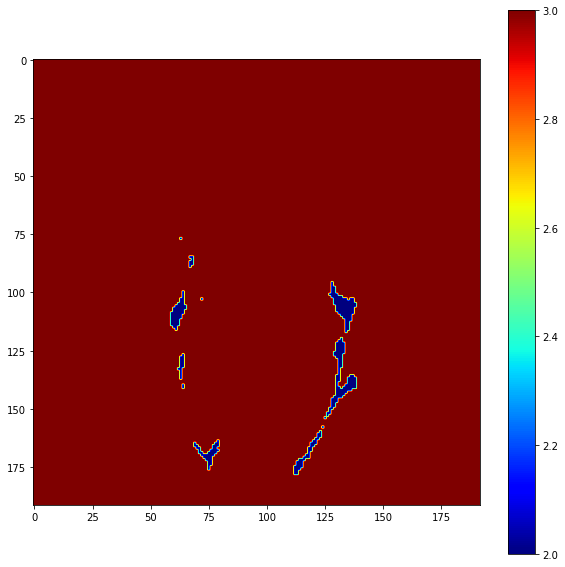

In [69]:
plt.figure(figsize=(10, 10))
plt.imshow(scale_map_repeat[0, 2, 55], cmap='jet')
plt.colorbar()
plt.show()

In [242]:
scales = [1.0, 1.3, 1.6, 2.5]

label_multi_scale_svls = list()

for scale in scales:
    label_scale_svls = scale_svls(label, operator=operator, scale_factor=scale)
    label_scale_svls_ = label_scale_svls.cpu().numpy()
    label_multi_scale_svls.append(label_scale_svls_)

label_multi_scale_svls = np.stack(label_multi_scale_svls, axis=-1)

label_multi_scale_svls.shape


/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(1, 4, 128, 192, 192, 4)

In [52]:
label_svls_ = label_svls.cpu().numpy()

label_multi_scale_svls_mix = np.zeros_like(label_svls_)

label_multi_scale_svls_mix.shape

label_multi_scale_svls_mix = \
    np.where(scale_map_repeat==0, label_multi_scale_svls[..., 0], label_multi_scale_svls_mix)
label_multi_scale_svls_mix = \
    np.where(scale_map_repeat==1, label_multi_scale_svls[..., 1], label_multi_scale_svls_mix)
label_multi_scale_svls_mix = \
    np.where(scale_map_repeat==2, label_multi_scale_svls[..., 2], label_multi_scale_svls_mix)
label_multi_scale_svls_mix = \
    np.where(scale_map_repeat==3, label_multi_scale_svls[..., 3], label_multi_scale_svls_mix)

label_multi_scale_svls_mix.shape

(1, 4, 128, 192, 192)

In [59]:
label_oh_ = label_oh.cpu().numpy()
label_svls_ = label_svls.cpu().numpy()
label_scale_svls_ = label_scale_svls.cpu().numpy()

diff_multi_original = label_multi_scale_svls_mix - label_svls_
diff_multi_scale = label_multi_scale_svls_mix - label_scale_svls_

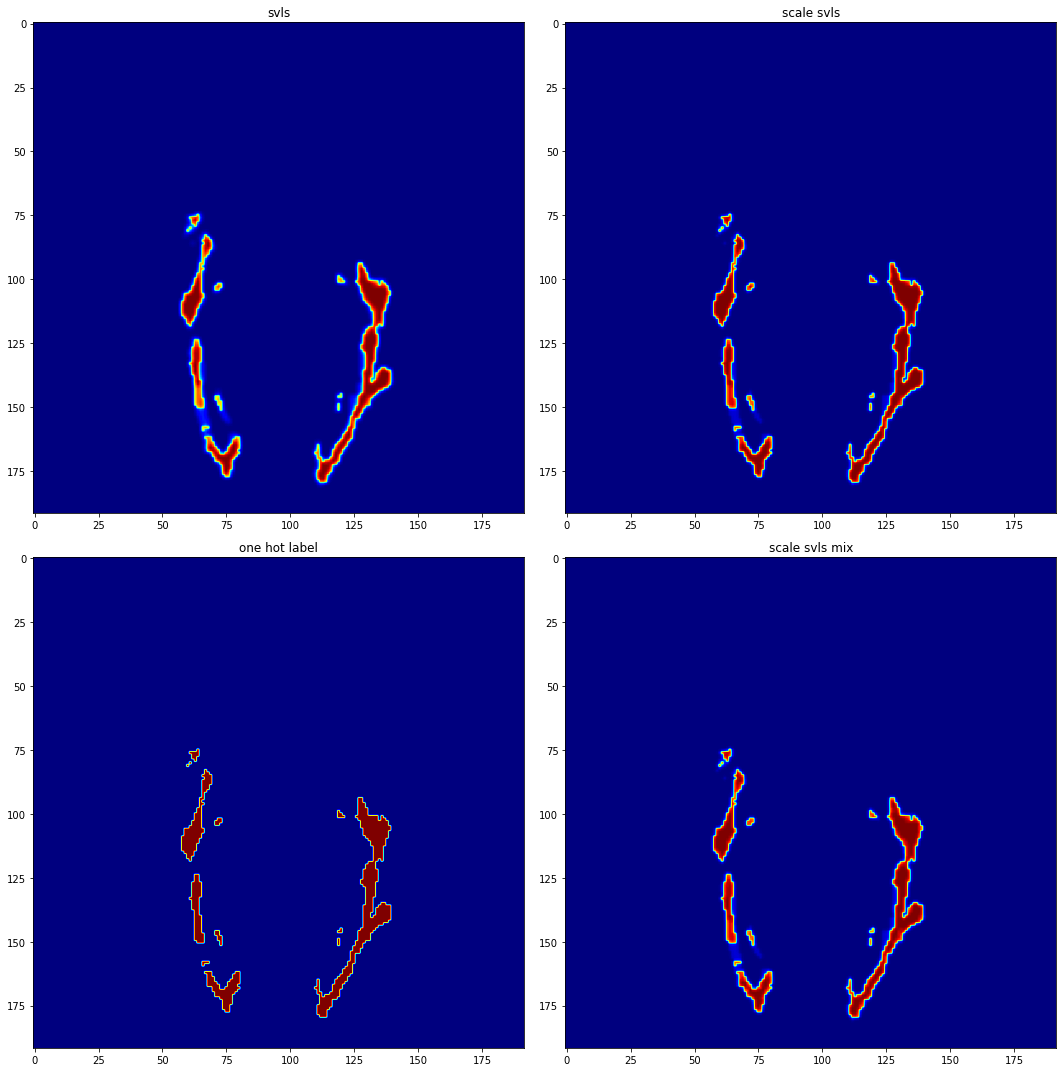

In [64]:
depth = 55

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs.ravel()

ax1.imshow(label_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax1.set_title("svls")
ax2.imshow(label_scale_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax2.set_title("scale svls")
ax3.imshow(label_oh[0, 2, depth,].cpu().numpy(), cmap="jet")
ax3.set_title("one hot label")
ax4.imshow(label_multi_scale_svls_mix[0, 2, depth,], cmap="jet")
ax4.set_title("scale svls mix")

plt.tight_layout()
plt.show()

In [70]:
diff_mix_original = label_multi_scale_svls_mix - label_svls.cpu().numpy()
diff_mix_scale = label_multi_scale_svls_mix - label_scale_svls.cpu().numpy()

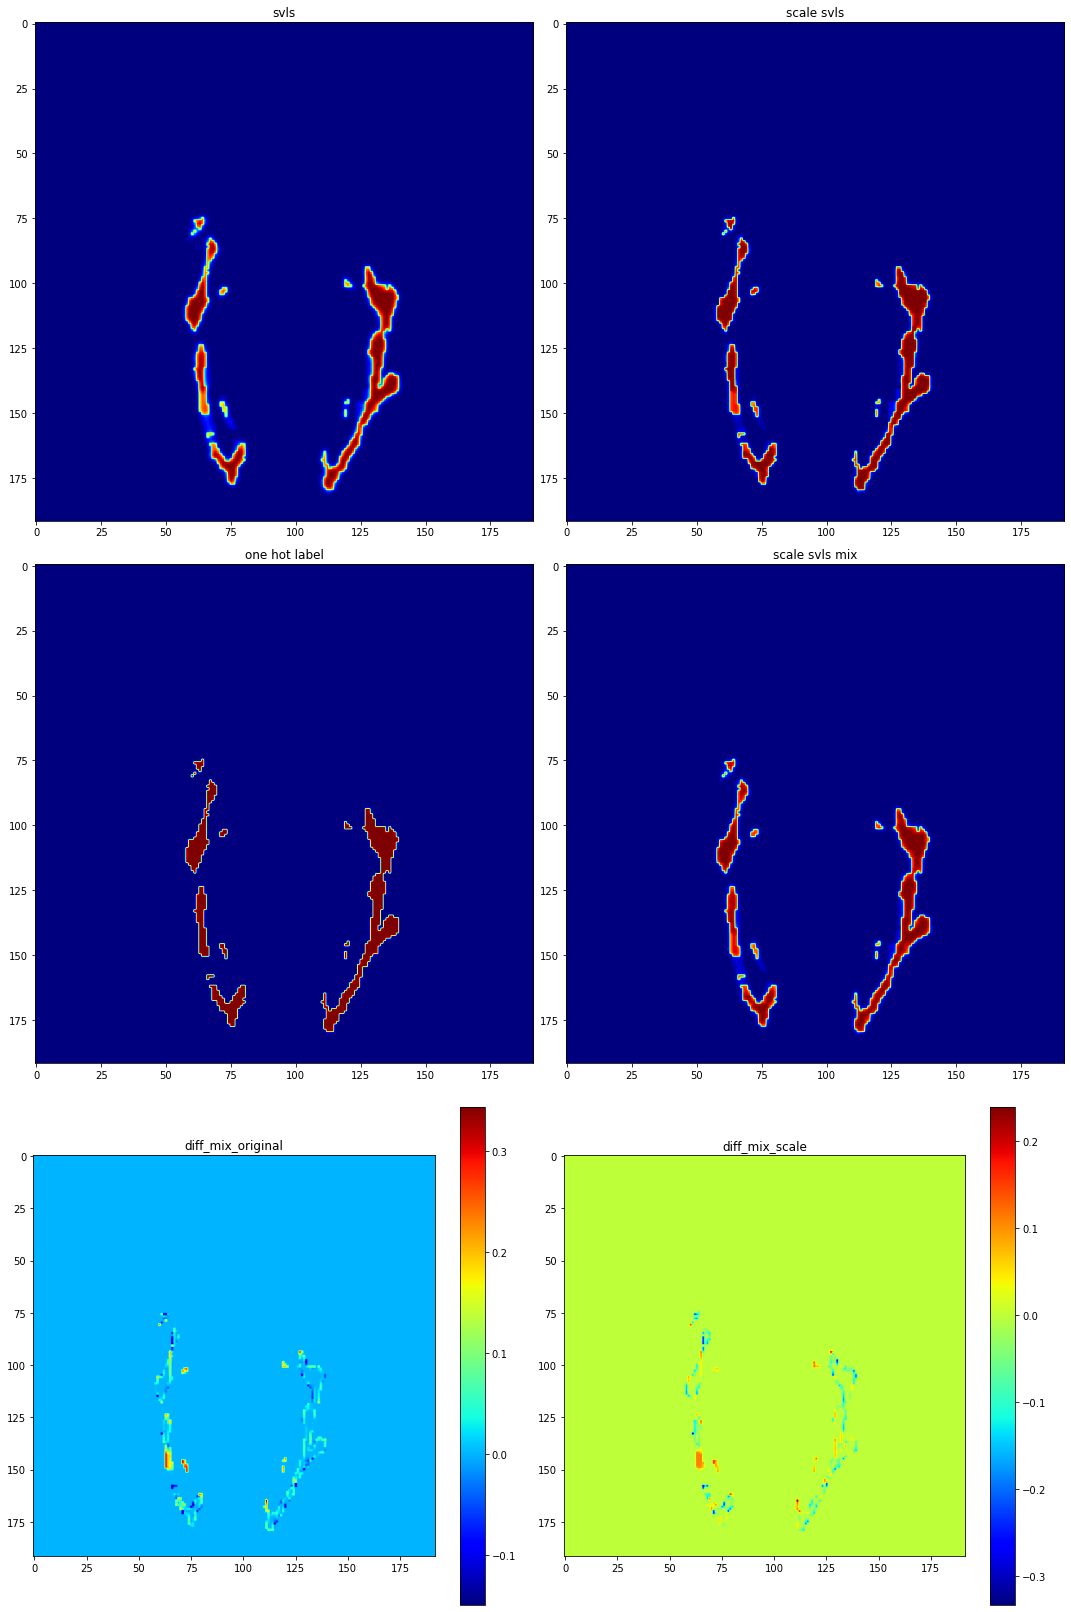

In [267]:
depth = 55

fig, axs = plt.subplots(3, 2, figsize=(15, 22.5))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.ravel()

ax1.imshow(label_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax1.set_title("svls")
ax2.imshow(label_scale_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax2.set_title("scale svls")
ax3.imshow(label_oh[0, 2, depth,].cpu().numpy(), cmap="jet")
ax3.set_title("one hot label")
ax4.imshow(label_multi_scale_svls_mix[0, 2, depth,], cmap="jet")
ax4.set_title("scale svls mix")
ax5_ = ax5.imshow(diff_mix_original[0, 2, depth,], cmap="jet")
ax5.set_title("diff_mix_original")
ax6_ = ax6.imshow(diff_mix_scale[0, 2, depth,], cmap="jet")
ax6.set_title("diff_mix_scale")
fig.colorbar(ax5_, ax=ax5)
fig.colorbar(ax6_, ax=ax6)

plt.tight_layout()
plt.show()

path2 腐蚀，获取连通域，连通域expand，每个连通域分别统计表面积/体积比，然后按照这个比值去确定各连通域合适的scale

In [163]:
dtm_domain_sv = np.ones_like(dtm[0, 1])

for i in range(1, num+1):  # exclude background
    # print(':' + str(i))
    # print(np.sum(label_domains==i))
    # print(np.unique(dtm[0, 1][label_domains==i]))
    surface_area = np.sum(dtm[0, 1][dtm_domains_expand==i]<2)
    volume = np.sum(dtm_domains_expand==i)
    # print(surface_area)
    # print(volume)
    dtm_domain_sv[dtm_domains_expand==i] = surface_area / volume

print(len(np.unique(dtm_domain_sv)))
print(np.unique(dtm_domain_sv))
print(dtm_domain_sv.shape)

dtm_domain_sv_scale = np.floor(dtm_domain_sv * 3).astype(np.uint8)

print(np.max(dtm_domain_sv_scale))
print(np.min(dtm_domain_sv_scale))

133
[0.31818182 0.35714286 0.4        0.42424242 0.44444444 0.45
 0.45238095 0.45454545 0.47169811 0.47433241 0.47826087 0.48275862
 0.49816219 0.5        0.52845528 0.53333333 0.53846154 0.53913043
 0.54166667 0.54285714 0.54347826 0.54545455 0.55471698 0.55555556
 0.5625     0.56666667 0.56818182 0.57132262 0.57256778 0.575
 0.57534247 0.58       0.58662614 0.58928571 0.59259259 0.5952381
 0.6        0.60377358 0.60595647 0.60663507 0.60714286 0.60891089
 0.6091954  0.60958585 0.6097561  0.61111111 0.61538462 0.61643836
 0.61878453 0.62745098 0.62765957 0.62921348 0.63       0.63013699
 0.63043478 0.63157895 0.63188406 0.63636364 0.63793103 0.63987138
 0.64285714 0.64516129 0.64705882 0.65517241 0.65591398 0.65656566
 0.65714286 0.65891473 0.65957447 0.66153846 0.66666667 0.66896552
 0.66942149 0.67058824 0.67150635 0.6744186  0.67692308 0.67741935
 0.67857143 0.68       0.68115942 0.68493151 0.69217391 0.69230769
 0.69281046 0.69354839 0.69387755 0.6969697  0.7        0.7015873
 0.7

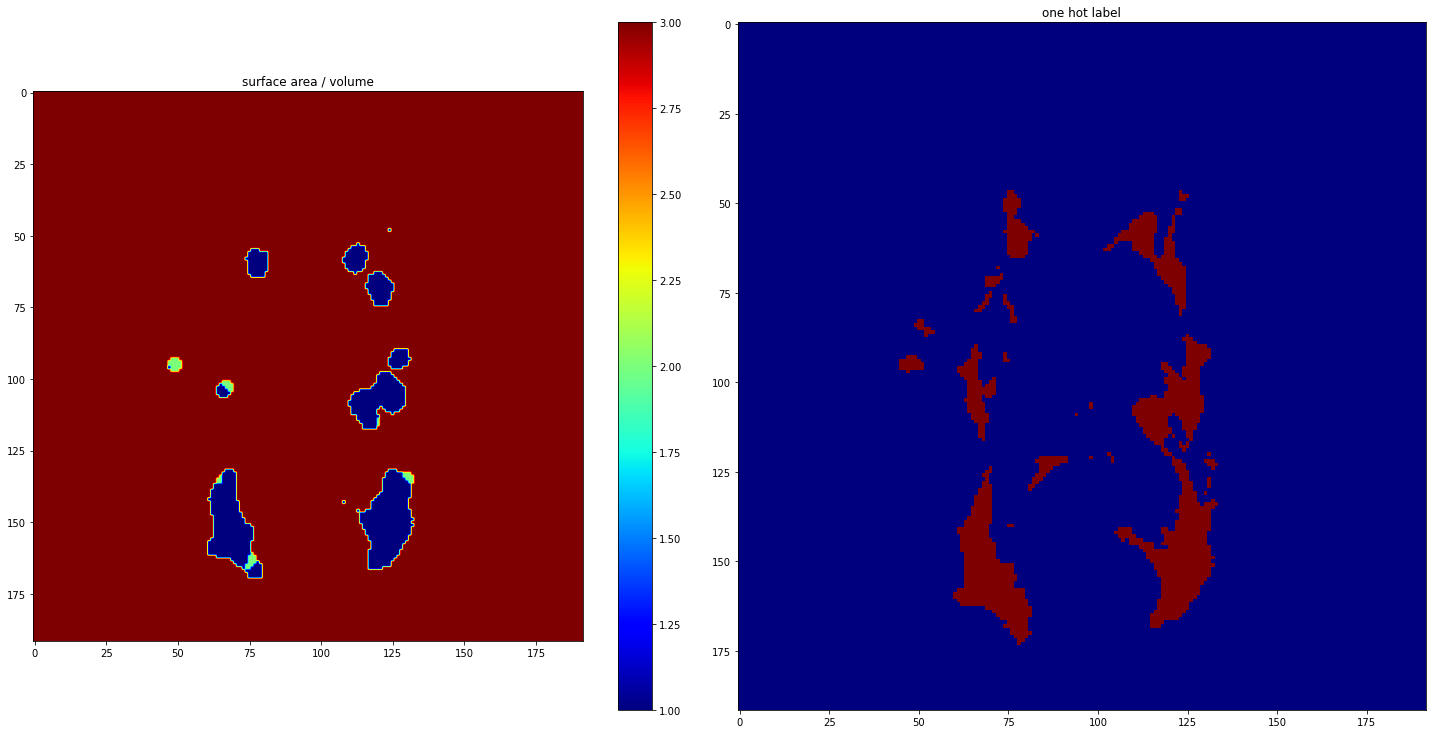

In [165]:
depth = 70

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axs.ravel()

ax1_ = ax1.imshow(dtm_domain_sv_scale[depth], cmap='jet')
ax1.set_title("surface area / volume")
fig.colorbar(ax1_, ax=ax1)
ax2.imshow(label_map[0, depth], cmap='jet')
ax2.set_title("one hot label")
plt.tight_layout()
plt.show()

In [166]:
label_svls_ = label_svls.cpu().numpy()

label_multi_scale_svls_sv_mix = np.zeros_like(label_svls_)

label_multi_scale_svls_sv_mix.shape

label_multi_scale_svls_sv_mix = \
    np.where(scale_map_repeat==0, label_multi_scale_svls[..., 0], label_multi_scale_svls_sv_mix)
label_multi_scale_svls_sv_mix = \
    np.where(scale_map_repeat==1, label_multi_scale_svls[..., 1], label_multi_scale_svls_sv_mix)
label_multi_scale_svls_sv_mix = \
    np.where(scale_map_repeat==2, label_multi_scale_svls[..., 2], label_multi_scale_svls_sv_mix)
label_multi_scale_svls_sv_mix = \
    np.where(scale_map_repeat==3, label_multi_scale_svls[..., 3], label_multi_scale_svls_sv_mix)

label_multi_scale_svls_sv_mix.shape

(1, 4, 128, 192, 192)

In [167]:
diff_mix_original = label_multi_scale_svls_sv_mix - label_svls.cpu().numpy()
diff_mix_scale = label_multi_scale_svls_sv_mix - label_scale_svls.cpu().numpy()

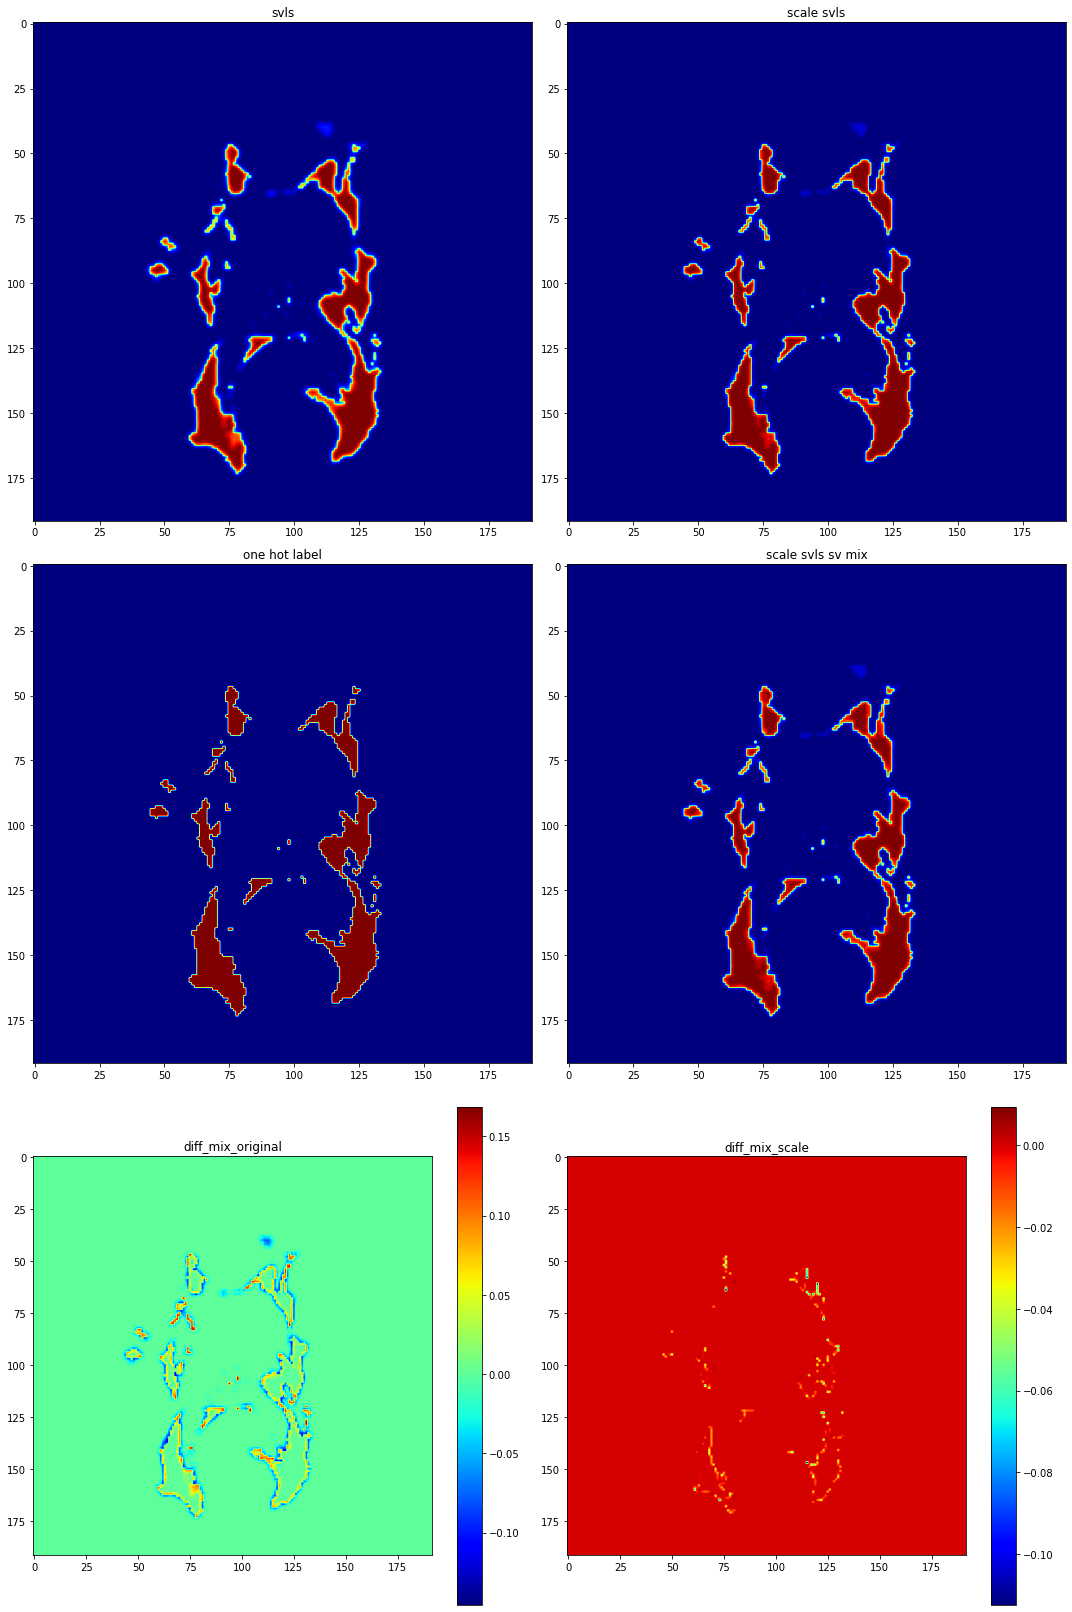

In [168]:
depth = 70

fig, axs = plt.subplots(3, 2, figsize=(15, 22.5))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.ravel()

ax1.imshow(label_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax1.set_title("svls")
ax2.imshow(label_scale_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax2.set_title("scale svls")
ax3.imshow(label_oh[0, 2, depth,].cpu().numpy(), cmap="jet")
ax3.set_title("one hot label")
ax4.imshow(label_multi_scale_svls_sv_mix[0, 2, depth,], cmap="jet")
ax4.set_title("scale svls sv mix")
ax5_ = ax5.imshow(diff_mix_original[0, 2, depth,], cmap="jet")
ax5.set_title("diff_mix_original")
ax6_ = ax6.imshow(diff_mix_scale[0, 2, depth,], cmap="jet")
ax6.set_title("diff_mix_scale")
fig.colorbar(ax5_, ax=ax5)
fig.colorbar(ax6_, ax=ax6)

plt.tight_layout()
plt.show()

path3 dtm+watershed

获取前景，得到dtm，watershed分割

In [260]:
from skimage import morphology, measure, segmentation, feature

label_oh_ = label_oh.cpu().numpy()

# get non-background voxel
label_foreground_ = (label_oh_[:, :1] == 0).astype(int)

# get distance transform map
label_foreground_dtm_ = distance(label_foreground_[0, 0])[None, None, ...]

# find peaks as markers
coords = feature.peak_local_max(label_foreground_dtm_[0, 0], footprint=np.ones((3, 3, 3)), labels=label_foreground_[0, 0])
mask = np.zeros(label_foreground_dtm_[0, 0].shape, dtype=int)
mask[tuple(coords.T)] = 1
markers = mask * label_foreground_dtm_

print(np.unique(markers))

# watershed
label_foreground_dtm_watershed_ = segmentation.watershed(-label_foreground_dtm_, markers, mask=label_foreground_)

# expand
label_foreground_dtm_watershed_expand_ = segmentation.expand_labels(label_foreground_dtm_watershed_, 3)

print(label_foreground_dtm_watershed_expand_.shape)

[ 0.          1.          1.41421356  1.73205081  2.          2.23606798
  2.44948974  2.82842712  3.          3.16227766  3.31662479  3.46410162
  3.60555128  3.74165739  4.          4.12310563  4.24264069  4.35889894
  4.47213595  4.58257569  4.69041576  4.89897949  5.          5.09901951
  5.19615242  5.38516481  5.47722558  5.74456265  5.83095189  5.91607978
  6.          6.08276253  6.164414    6.32455532  6.40312424  6.4807407
  7.          7.07106781  7.28010989  7.34846923  7.81024968  7.87400787
  8.06225775 11.44552314 14.35270009 14.45683229 14.52583905 14.56021978]
(1, 1, 128, 192, 192)


In [261]:
label_foreground_dtm_watershed_expand_clip_ = np.clip(label_foreground_dtm_watershed_expand_ / 10, 0, 1)

scale_map_ = np.round((1 - label_foreground_dtm_watershed_expand_clip_) * 3).astype(int)

print(np.unique(scale_map_))

[0 1 2 3]


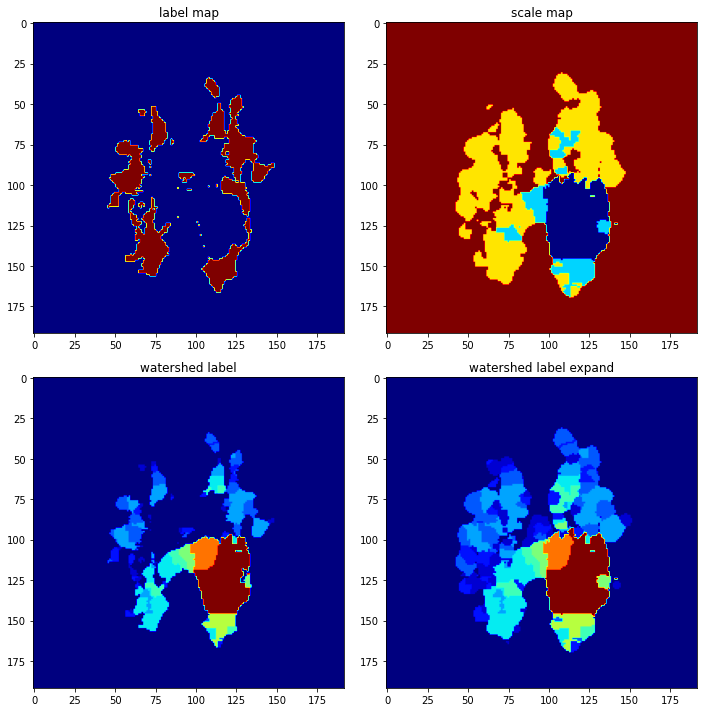

In [262]:
depth = 80

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.imshow(label_oh_[0, 2, depth], cmap='jet')
ax1.set_title('label map')
ax2.imshow(scale_map_[0, 0, depth], cmap='jet')
ax2.set_title('scale map')
ax3.imshow(label_foreground_dtm_watershed_[0, 0, depth], cmap='jet')
ax3.set_title('watershed label')
ax4.imshow(label_foreground_dtm_watershed_expand_[0, 0, depth], cmap='jet')
ax4.set_title('watershed label expand')

plt.tight_layout()
plt.show()

In [263]:
label_svls_water_mix_ = np.zeros_like(label_oh_)

label_svls_water_mix_.shape

label_svls_water_mix_ = \
    np.where(scale_map_==0, label_multi_scale_svls[..., 0], label_svls_water_mix_)
label_svls_water_mix_ = \
    np.where(scale_map_==1, label_multi_scale_svls[..., 1], label_svls_water_mix_)
label_svls_water_mix_ = \
    np.where(scale_map_==2, label_multi_scale_svls[..., 2], label_svls_water_mix_)
label_svls_water_mix_ = \
    np.where(scale_map_==3, label_multi_scale_svls[..., 3], label_svls_water_mix_)

label_svls_water_mix_.shape

(1, 4, 128, 192, 192)

In [264]:
label_scale_svls = scale_svls(label, scale_factor=2.2)

diff_mix_original = label_svls_water_mix_ - label_svls.cpu().numpy()
diff_mix_scale = label_svls_water_mix_ - label_scale_svls.cpu().numpy()

diff_mix_original = diff_mix_original * label_oh_[:, 2:3, ...]
diff_mix_scale = diff_mix_scale * label_oh_[:, 2:3, ...]

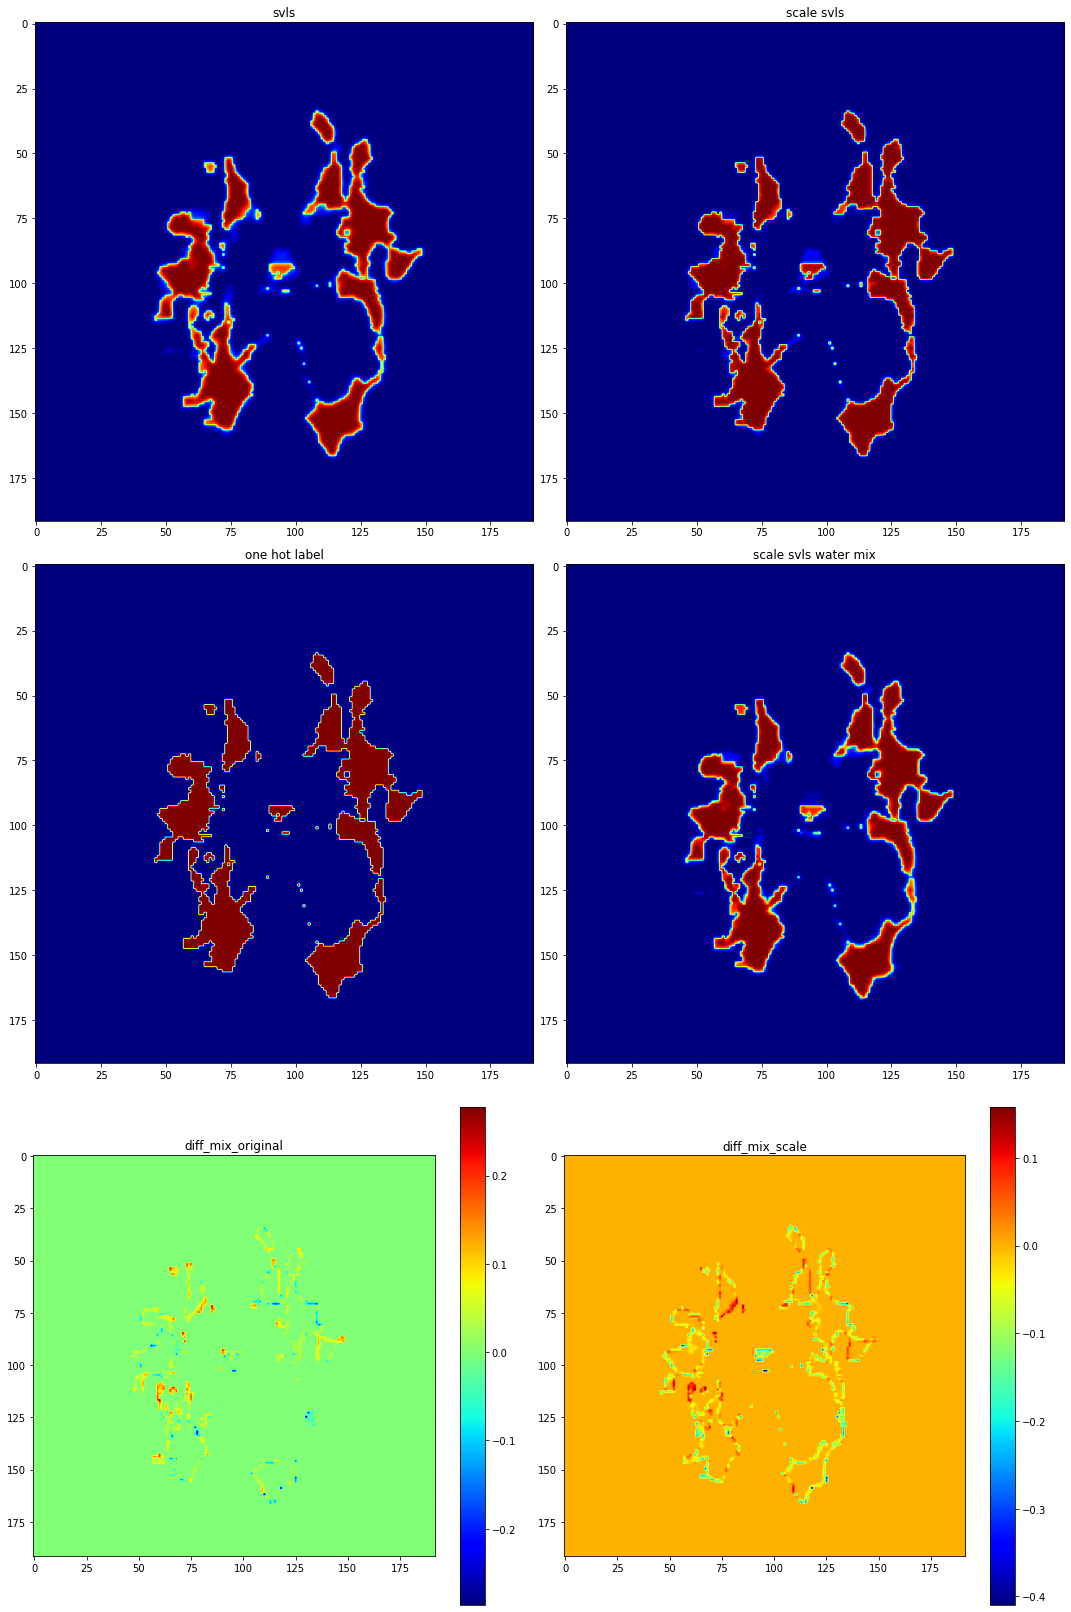

In [265]:
depth = 80

fig, axs = plt.subplots(3, 2, figsize=(15, 22.5))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.ravel()

ax1.imshow(label_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax1.set_title("svls")
ax2.imshow(label_scale_svls[0, 2, depth,].cpu().numpy(), cmap="jet")
ax2.set_title("scale svls")
ax3.imshow(label_oh[0, 2, depth,].cpu().numpy(), cmap="jet")
ax3.set_title("one hot label")
ax4.imshow(label_svls_water_mix_[0, 2, depth,], cmap="jet")
ax4.set_title("scale svls water mix")
ax5_ = ax5.imshow(diff_mix_original[0, 2, depth,], cmap="jet")
ax5.set_title("diff_mix_original")
ax6_ = ax6.imshow(diff_mix_scale[0, 2, depth,], cmap="jet")
ax6.set_title("diff_mix_scale")
fig.colorbar(ax5_, ax=ax5)
fig.colorbar(ax6_, ax=ax6)

plt.tight_layout()
plt.show()

path4] clip，控制smooth后的下限，防止过度滤波

In [ ]:
alpha = 0.1


In [305]:
test_oh = np.array([1, 0, 0, 0])
test_svls = np.array([0.8, 0.13, 0.02, 0.05])

alpha = 0.1

target_component = test_oh - alpha
other_component = alpha / (1 - 0.8) * test_svls

print(target_component)

print(other_component)

np.sum(target_component[:1]) + np.sum(other_component[1:])

print(test_svls)
print(np.concatenate((target_component[:1], other_component[1:])))

[ 0.9 -0.1 -0.1 -0.1]
[0.4   0.065 0.01  0.025]
[0.8  0.13 0.02 0.05]
[0.9   0.065 0.01  0.025]


不resize label map，改变卷积核参数 - 效果不佳

In [61]:
svls_1_5 = SVLS(4, sigma=1e-6, kernel_size=5).cuda()
label_svls_1_5 = svls_1_5(label)

svls_10000_5 = SVLS(4, sigma=1e7, kernel_size=5).cuda()
label_svls_10000_5 = svls_10000_5(label)

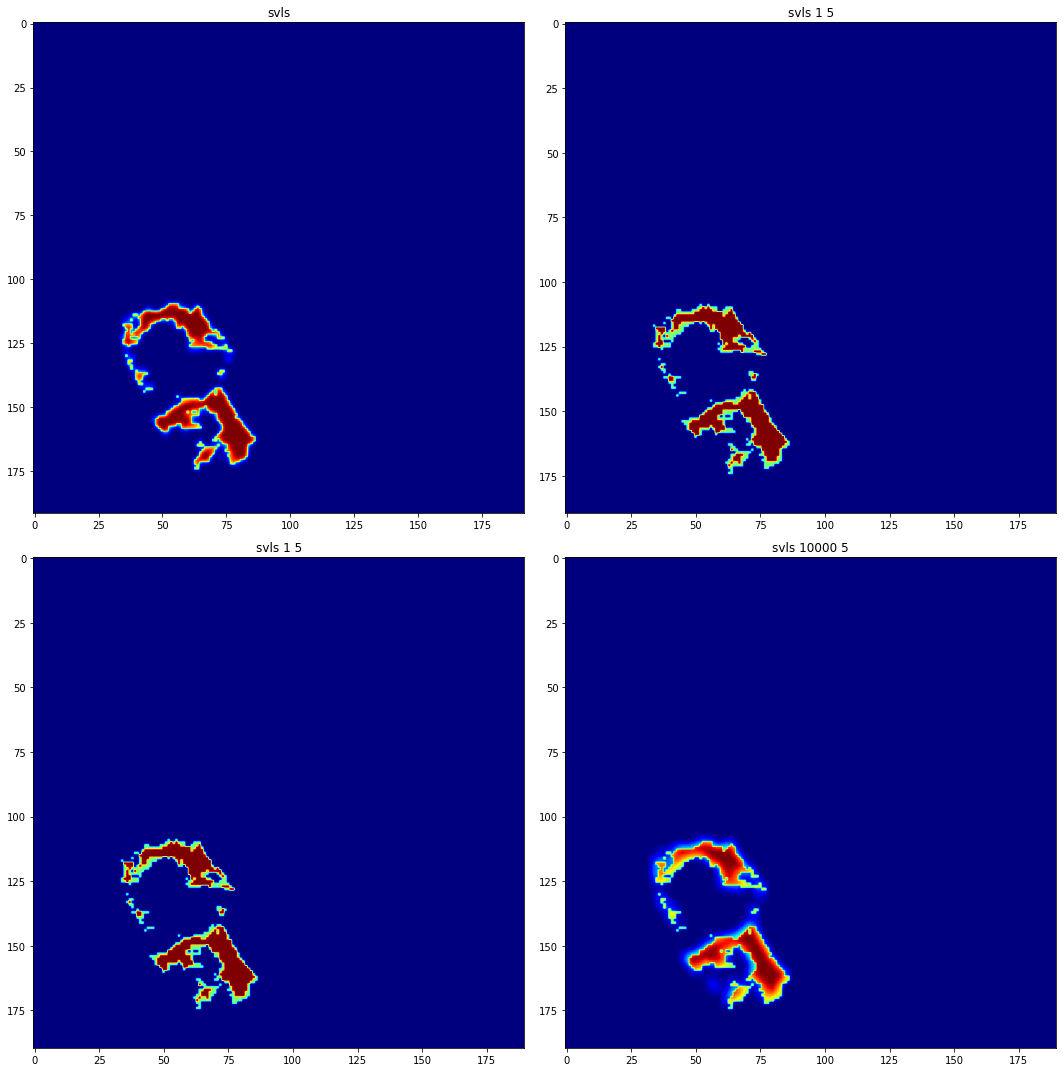

In [62]:
depth = 60

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs.ravel()

ax1.imshow(label_svls[0, 2, depth].cpu().numpy(), cmap="jet")
ax1.set_title("svls")
ax2.imshow(label_svls_1_5[0, 2, depth].cpu().numpy(), cmap="jet")
ax2.set_title("svls 1 5")
ax3.imshow(label_svls_1_5[0, 2, depth].cpu().numpy(), cmap="jet")
ax3.set_title("svls 1 5")
ax4.imshow(label_svls_10000_5[0, 2, depth].cpu().numpy(), cmap="jet")
ax4.set_title("svls 10000 5")

plt.tight_layout()
plt.show()